BSM模型

In [1]:
import numpy as np
import math
import seaborn as sns
from matplotlib import pylab


In [2]:
import scipy as sp
from scipy.linalg import solve_banded

In [3]:
class BSMModel:

    def __init__(self, s0, r, sigma):
        self.s0 = s0
        self.x0 = math.log(s0)
        self.r = r
        self.sigma = sigma

    def log_expectation(self, T):
        return self.x0 + (self.r - 0.5 * self.sigma * self.sigma) * T

    def expectation(self, T):
        return math.exp(self.log_expectation(T))

    def x_max(self, T):
        return self.log_expectation(T) + 4.0 * self.sigma * math.sqrt(T)

    def x_min(self, T):
        return self.log_expectation(T) - 4.0 * self.sigma * math.sqrt(T)

In [4]:
class CallOption:

    def __init__(self, strike):
        self.k = strike

    def ic(self, spot):
        return max(spot - self.k, 0.0)

    def bcl(self, spot, tau, model):
        return 0.0

    def bcr(self, spot, tau, model):
        return spot - math.exp(-model.r*tau) * self.k

In [7]:
class BSMScheme:
    def __init__(self, model, payoff, T, M, N):
        self.model = model
        self.T = T
        self.M = M
        self.N = N
        self.dt = self.T / self.M
        self.payoff = payoff
        self.x_min = model.x_min(self.T)
        self.x_max = model.x_max(self.T)
        self.dx = (self.x_max - self.x_min) / self.N
        self.C = np.zeros((self.N+1, self.M+1)) # 全部网格
        self.xArray = np.linspace(self.x_min, self.x_max, self.N+1)
        self.C[:,0] = list(map(self.payoff.ic, np.exp(self.xArray)))

        sigma_square = self.model.sigma*self.model.sigma
        r = self.model.r

        self.l_j = -(0.5*sigma_square*self.dt/self.dx/self.dx - 0.5 * (r - 0.5 * sigma_square)*self.dt/self.dx)
        self.c_j = 1.0 + sigma_square*self.dt/self.dx/self.dx + r*self.dt
        self.u_j = -(0.5*sigma_square*self.dt/self.dx/self.dx + 0.5 * (r - 0.5 * sigma_square)*self.dt/self.dx)

    def roll_back(self):

        for k in range(0, self.M):
            udiag = np.ones(self.N-1) * self.u_j
            ldiag =  np.ones(self.N-1) * self.l_j
            cdiag =  np.ones(self.N-1) * self.c_j

            mat = np.zeros((3,self.N-1))
            mat[0,:] = udiag
            mat[1,:] = cdiag
            mat[2,:] = ldiag
            rhs = np.copy(self.C[1:self.N,k])

            # 应用左端边值条件
            v1 = self.payoff.bcl(math.exp(self.x_min), (k+1)*self.dt, self.model)
            rhs[0] -= self.l_j * v1

            # 应用右端边值条件
            v2 = self.payoff.bcr(math.exp(self.x_max), (k+1)*self.dt, self.model)
            rhs[-1] -= self.u_j * v2

            x = solve_banded((1,1), mat, rhs)
            self.C[1:self.N, k+1] = x
            self.C[0][k+1] = v1
            self.C[self.N][k+1] = v2

    def mesh_grids(self):
        tArray = np.linspace(0, self.T, self.M+1)
        tGrids, xGrids = np.meshgrid(tArray, self.xArray)
        return tGrids, xGrids

In [8]:
model = BSMModel(100.0, 0.05, 0.2)
payoff = CallOption(105.0)
scheme = BSMScheme(model, payoff, 5.0, 100, 300)

In [9]:
scheme.roll_back()

Text(0, 0.5, '$C$')

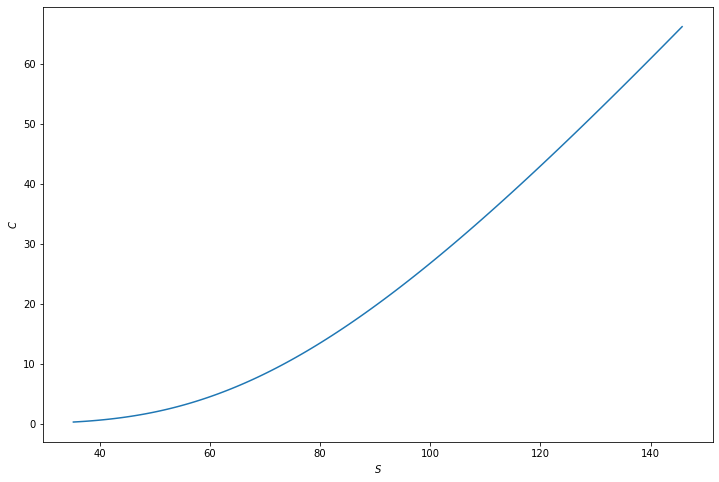

In [10]:
from matplotlib import pylab
pylab.figure(figsize=(12,8))
pylab.plot(np.exp(scheme.xArray)[50:170], scheme.C[50:170,-1])
pylab.xlabel('$S$')
pylab.ylabel('$C$')